<a href="https://colab.research.google.com/github/DamnScallion/Visionary-Unicorns-Project/blob/main/yolo/testing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Clone files from our GitHub Repo

In [1]:
!git clone https://github.com/DamnScallion/Visionary-Unicorns-Project.git

Cloning into 'Visionary-Unicorns-Project'...
remote: Enumerating objects: 10991, done.
remote: Counting objects: 100% (50/50), done.
remote: Compressing objects: 100% (46/46), done.
remote: Total 10991 (delta 23), reused 8 (delta 2), pack-reused 10941
Receiving objects: 100% (10991/10991), 87.81 MiB | 17.59 MiB/s, done.
Resolving deltas: 100% (69/69), done.
Updating files: 100% (10836/10836), done.


In [2]:
!pip install ultralytics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 608.0/608.0 kB 9.9 MB/s eta 0:00:00


In [18]:
import matplotlib.pyplot as plt
from ultralytics import YOLO
import os

In [19]:
ROOT_DIR = '/content/Visionary-Unicorns-Project/yolo'

In [20]:
import cv2
from google.colab.patches import cv2_imshow
import math
import matplotlib.pyplot as plt

In [21]:
trained_model = YOLO(os.path.join(ROOT_DIR, 'runs/detect/train-augmented-imgsz-224/weights/best.pt'))

In [22]:
# Function to perform object detection
def detection(img_path, model):
  # Load image
  img = cv2.imread(img_path)

  # Perform object detection
  results = model.predict(source = img)

  # print(f'results = {results}')

  # Extract bounding boxes
  boxes = results[0].boxes
  print(f'boxes length = {len(boxes)}')

  bounding_boxes = []

  for box in boxes:
    left, top, right, bottom = box.xyxy[0]
    # left, top, right, bottom = int(left), int(top), int(right), int(bottom)
    left, top, right, bottom = int(math.ceil(left)), int(math.ceil(top)), int(math.ceil(right)), int(math.ceil(bottom))
    print(left, top, right, bottom)
    print(f'box = {box}')

    cls_id = int(list(box.cls)[0])

    print(f'cls_id = {cls_id}')

    bounding_boxes.append((left, top, right, bottom))

  return bounding_boxes

In [23]:
# VAL_DIR = '/content/drive/My Drive/Visionary-Unicorns-Project'
VAL_DIR = '/content/Visionary-Unicorns-Project'


0: 224x224 1 penguin, 11.1ms
Speed: 1.4ms preprocess, 11.1ms inference, 2.6ms postprocess per image at shape (1, 3, 224, 224)
WARNING ⚠️ 'Boxes.boxes' is deprecated. Use 'Boxes.data' instead.


boxes length = 1
213 90 534 615
box = ultralytics.engine.results.Boxes object with attributes:

boxes: tensor([[212.7314,  89.5929, 533.0101, 614.0706,   0.8771,   0.0000]], device='cuda:0')
cls: tensor([0.], device='cuda:0')
conf: tensor([0.8771], device='cuda:0')
data: tensor([[212.7314,  89.5929, 533.0101, 614.0706,   0.8771,   0.0000]], device='cuda:0')
id: None
is_track: False
orig_shape: (640, 640)
shape: torch.Size([1, 6])
xywh: tensor([[372.8707, 351.8317, 320.2787, 524.4777]], device='cuda:0')
xywhn: tensor([[0.5826, 0.5497, 0.5004, 0.8195]], device='cuda:0')
xyxy: tensor([[212.7314,  89.5929, 533.0101, 614.0706]], device='cuda:0')
xyxyn: tensor([[0.3324, 0.1400, 0.8328, 0.9595]], device='cuda:0')
cls_id = 0


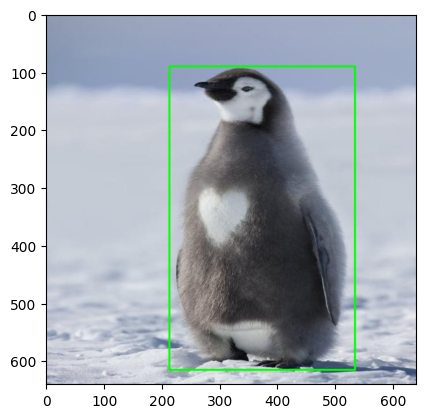

In [26]:
# Example usage
image_path = os.path.join(VAL_DIR, 'data/original/valid/image_id_000.jpg')

image = cv2.imread(image_path)

bounding_boxes = detection(image_path, trained_model)

# Draw bounding boxes on the image
for (left, top, right, bottom) in bounding_boxes:
    start_point = (left, top)
    end_point = (right, bottom)
    color = (0, 255, 0)
    thickness = 2
    lineType = cv2.LINE_AA
    cv2.rectangle(image, start_point, end_point, color, thickness, lineType)

plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
# cv2_imshow(image)
# cv2.waitKey(0)
# cv2.destroyAllWindows()